In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
# Install PySpark
# !pip install -q pyspark

# Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF,NGram, VectorAssembler
from pyspark.ml import Pipeline

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(f"PySpark Version: {pyspark.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

PySpark Version: 3.5.5
TensorFlow Version: 2.18.0


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-reviews


In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("AmazonReviews").getOrCreate()


file_path = '/kaggle/input/amazon-reviews/train.csv'
file_path1 = '/kaggle/input/amazon-reviews/test.csv'

df_train = spark.read.csv(
    file_path,
    schema="polarity INT, title STRING, text STRING"
)

df_test = spark.read.csv(
    file_path1,
    schema="polarity INT, title STRING, text STRING"
)

# Show the result - it will be perfectly structured!
print("Successfully loaded and parsed data:")
df_train.show(5, truncate=True)
df_test.show(5, truncate=True)

# You can also check the schema
print("\nDataFrame Schema:")
df_train.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/09 12:38:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Successfully loaded and parsed data:


+--------+--------------------+--------------------+
|polarity|               title|                text|
+--------+--------------------+--------------------+
|       2|Stuning even for ...|This sound track ...|
|       2|The best soundtra...|I'm reading a lot...|
|       2|            Amazing!|"This soundtrack ...|
|       2|Excellent Soundtrack|I truly like this...|
|       2|Remember, Pull Yo...|If you've played ...|
+--------+--------------------+--------------------+
only showing top 5 rows

+--------+--------------------+--------------------+
|polarity|               title|                text|
+--------+--------------------+--------------------+
|       2|            Great CD|"My lovely Pat ha...|
|       2|One of the best g...|Despite the fact ...|
|       1|Batteries died wi...|I bought this cha...|
|       2|works fine, but M...|Check out Maha En...|
|       2|Great for the non...|Reviewed quite a ...|
+--------+--------------------+--------------------+
only showing top 5 ro

In [5]:
print("Combining 'title' and 'text' columns...")
df_combined = df_train.withColumn(
    "full_text",
    F.concat_ws(" ", df_train['title'], df_train['text'])
)
df_combined_test = df_test.withColumn(
    "full_text",
    F.concat_ws(" ", df_test['title'], df_test['text'])
)

Combining 'title' and 'text' columns...


In [6]:
print("Adjusting polarity label to be 0 or 1...")
df_labeled = df_combined.withColumn("label", df_combined['polarity'] - 1)
df_labeled_test = df_combined_test.withColumn("label", df_combined_test['polarity'] - 1)

# 3. Select only the columns we need and drop rows with no text.
df_clean = df_labeled.select("label", "full_text").dropna()
df_clean_test = df_labeled_test.select("label", "full_text").dropna()

print("\nData after cleaning and combining:")
df_clean.show(5, truncate=50)
df_clean_test.show(5, truncate=50)

Adjusting polarity label to be 0 or 1...

Data after cleaning and combining:
+-----+--------------------------------------------------+
|label|                                         full_text|
+-----+--------------------------------------------------+
|    1|Stuning even for the non-gamer This sound track...|
|    1|The best soundtrack ever to anything. I'm readi...|
|    1|Amazing! "This soundtrack is my favorite music ...|
|    1|Excellent Soundtrack I truly like this soundtra...|
|    1|Remember, Pull Your Jaw Off The Floor After Hea...|
+-----+--------------------------------------------------+
only showing top 5 rows

+-----+--------------------------------------------------+
|label|                                         full_text|
+-----+--------------------------------------------------+
|    1|Great CD "My lovely Pat has one of the GREAT vo...|
|    1|One of the best game music soundtracks - for a ...|
|    0|Batteries died within a year ... I bought this ...|
|    1|works 

In [7]:
df_clean.groupBy("label").count().orderBy("label").show()

+-----+-------+
|label|  count|
+-----+-------+
|    0|1800000|
|    1|1800000|
+-----+-------+



In [47]:
UNIGRAM_VOCAB_SIZE = 15000
BIGRAM_VOCAB_SIZE = 10000 

# --- Define the NEW Pipeline Stages ---
print("Defining the new N-gram pipeline...")

# Stages 1 & 2: Same as before
tokenizer = Tokenizer(inputCol="full_text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# --- Unigram (single word) feature stream ---
unigram_vectorizer = CountVectorizer(
    inputCol="filtered_words",
    outputCol="unigram_raw_features", # Give it a unique name
    vocabSize=UNIGRAM_VOCAB_SIZE
)

# --- Bigram (2-word phrase) feature stream ---
# Stage 3: Create the bigrams
ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")

# Stage 4: Vectorize the bigrams
bigram_vectorizer = CountVectorizer(
    inputCol="bigrams",
    outputCol="bigram_raw_features", # Give it a unique name
    vocabSize=BIGRAM_VOCAB_SIZE
)

# --- Combine Feature Streams ---
# Stage 5: Use VectorAssembler to combine both feature vectors
assembler = VectorAssembler(
    inputCols=["unigram_raw_features", "bigram_raw_features"],
    outputCol="combined_raw_features"
)

# Stage 6: Apply IDF to the final combined vector
idf = IDF(inputCol="combined_raw_features", outputCol="features")

# Assemble the full pipeline in the correct order
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    unigram_vectorizer, # Unigram stream
    ngram,              # Bigram stream part 1
    bigram_vectorizer,  # Bigram stream part 2
    assembler,          # Combine streams
    idf                 # Final IDF step
])



Defining the new N-gram pipeline...


In [48]:
print("Fitting pipeline...")
#can only fit on training data
pipeline_model = pipeline.fit(df_clean)

Fitting pipeline...


25/06/09 14:04:27 WARN MemoryStore: Not enough space to cache rdd_104_2 in memory! (computed 62.7 MiB so far)
25/06/09 14:04:27 WARN BlockManager: Persisting block rdd_104_2 to disk instead.
25/06/09 14:04:27 WARN MemoryStore: Not enough space to cache rdd_104_0 in memory! (computed 18.7 MiB so far)
25/06/09 14:04:27 WARN BlockManager: Persisting block rdd_104_0 to disk instead.
25/06/09 14:04:27 WARN MemoryStore: Not enough space to cache rdd_104_3 in memory! (computed 42.5 MiB so far)
25/06/09 14:04:27 WARN BlockManager: Persisting block rdd_104_3 to disk instead.
25/06/09 14:04:32 WARN MemoryStore: Not enough space to cache rdd_104_1 in memory! (computed 150.2 MiB so far)
25/06/09 14:04:32 WARN BlockManager: Persisting block rdd_104_1 to disk instead.
25/06/09 14:04:47 WARN MemoryStore: Not enough space to cache rdd_104_2 in memory! (computed 159.6 MiB so far)
25/06/09 14:04:47 WARN MemoryStore: Not enough space to cache rdd_104_0 in memory! (computed 8.6 MiB so far)
25/06/09 14:04:

In [49]:
train_df = pipeline_model.transform(df_clean).select("label", "features")
test_df = pipeline_model.transform(df_clean_test).select("label", "features")

print("\nPreprocessing of both datasets is complete and correct!")
print(f"Final training features count: {train_df.count()}")
print(f"Final testing features count: {test_df.count()}")


Preprocessing of both datasets is complete and correct!


Final training features count: 3600000


Final testing features count: 400000


In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.sparse import vstack
import matplotlib.pyplot as plt

In [51]:
# print("Converting Spark DataFrames to Pandas DataFrames...")
# train_pdf = train_df.toPandas()
# test_pdf = test_df.toPandas()


# print(f"Training data shape (Pandas): {train_pdf.shape}")
# print(f"Testing data shape (Pandas): {test_pdf.shape}")

In [52]:
import pyarrow.parquet as pq
import numpy as np

def batch_generator(file_path, batch_size, vocab_size):
    """
    Reads a Parquet dataset directory by iterating through its fragments.
    """
    dataset = pq.ParquetDataset(file_path)

    # FIX: Iterate through each file 'fragment' in the dataset
    for fragment in dataset.fragments:
        # The .to_batches() method exists on each fragment
        for batch in fragment.to_batches(batch_size=batch_size):
            df_batch = batch.to_pandas()
            y = df_batch['label'].to_numpy(dtype=np.int32)
            X = np.zeros((len(df_batch), vocab_size), dtype=np.float32)
            for i, row in enumerate(df_batch['features']):
                X[i, row['indices']] = row['values']
            yield X, y

In [53]:
train_output_path = "/kaggle/working/train_processed.parquet"
test_output_path = "/kaggle/working/test_processed.parquet"

print(f"Saving processed training data to: {train_output_path}")
train_df.write.mode("overwrite").parquet(train_output_path)

print(f"Saving processed testing data to: {test_output_path}")
test_df.write.mode("overwrite").parquet(test_output_path)

print("Successfully saved processed data.")

Saving processed training data to: /kaggle/working/train_processed.parquet


Saving processed testing data to: /kaggle/working/test_processed.parquet


Successfully saved processed data.


In [54]:
BATCH_SIZE = 512
VOCAB_SIZE = UNIGRAM_VOCAB_SIZE + BIGRAM_VOCAB_SIZE

# --- Create tf.data.Dataset objects from our generator ---
print("Creating tf.data.Dataset for training...")
train_dataset = tf.data.Dataset.from_generator(
    lambda: batch_generator(train_output_path, BATCH_SIZE, VOCAB_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE).repeat()

print("Creating tf.data.Dataset for validation...")
test_dataset = tf.data.Dataset.from_generator(
    lambda: batch_generator(test_output_path, BATCH_SIZE, VOCAB_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE).repeat()

Creating tf.data.Dataset for training...
Creating tf.data.Dataset for validation...


In [55]:

model = keras.Sequential([
    layers.Input(shape=(VOCAB_SIZE,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer='adam',               
    loss='binary_crossentropy',      
    metrics=['accuracy']            
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │       3,200,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,208,449 (12.24 MB)

 Trainable params: 3,208,449 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
num_train_samples = 2880000 # Roughly 80% of 3.6 million
num_test_samples = 720000  # Roughly 20% of 3.6 million
steps_per_epoch = num_train_samples // BATCH_SIZE
validation_steps = num_test_samples // BATCH_SIZE

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

early_stopper = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',       # The metric to monitor
    mode='min',               # We want to minimize the validation loss
    save_best_only=True,      # Only save the model if `val_loss` has improved
    verbose=1
)
learning_rate_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    verbose=1
)

In [58]:
print("\nStarting model training with batch processing...")
history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopper,model_checkpoint,learning_rate_scheduler],
    verbose=1
)


Starting model training with batch processing...
Epoch 1/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 526s 93ms/step - accuracy: 0.8789 - loss: 0.2881 - val_accuracy: 0.9027 - val_loss: 0.2364
Epoch 2/15
   3/5625 ━━━━━━━━━━━━━━━━━━━━ 4:00 43ms/step - accuracy: 0.8892 - loss: 0.2317

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 176s 31ms/step - accuracy: 0.9021 - loss: 0.2393 - val_accuracy: 0.9039 - val_loss: 0.2340
Epoch 3/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 520s 92ms/step - accuracy: 0.9025 - loss: 0.2370 - val_accuracy: 0.9067 - val_loss: 0.2286
Epoch 4/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 179s 32ms/step - accuracy: 0.9122 - loss: 0.2181 - val_accuracy: 0.9069 - val_loss: 0.2278
Epoch 5/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 523s 93ms/step - accuracy: 0.9120 - loss: 0.2181 - val_accuracy: 0.9077 - val_loss: 0.2284
Epoch 6/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 178s 32ms/step - accuracy: 0.9202 - loss: 0.2019 - val_accuracy: 0.9074 - val_loss: 0.2270
Epoch 7/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 504s 89ms/step - accuracy: 0.9194 - loss: 0.2028 - val_accuracy: 0.9076 - val_loss: 0.2291
Epoch 8/15
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 175s 31ms/step - accuracy: 0.9261 - loss: 0.1892 - val_accuracy: 0.9072 - val_loss: 0.2287


In [59]:
print("\nEvaluating model performance on the test set...")
results = model.evaluate(
    test_dataset,
    steps=validation_steps, # Tell it how many batches to evaluate
    verbose=1
)

print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")


Evaluating model performance on the test set...
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 63s 45ms/step - accuracy: 0.9065 - loss: 0.2295

Test Loss: 0.2270
Test Accuracy: 0.9074


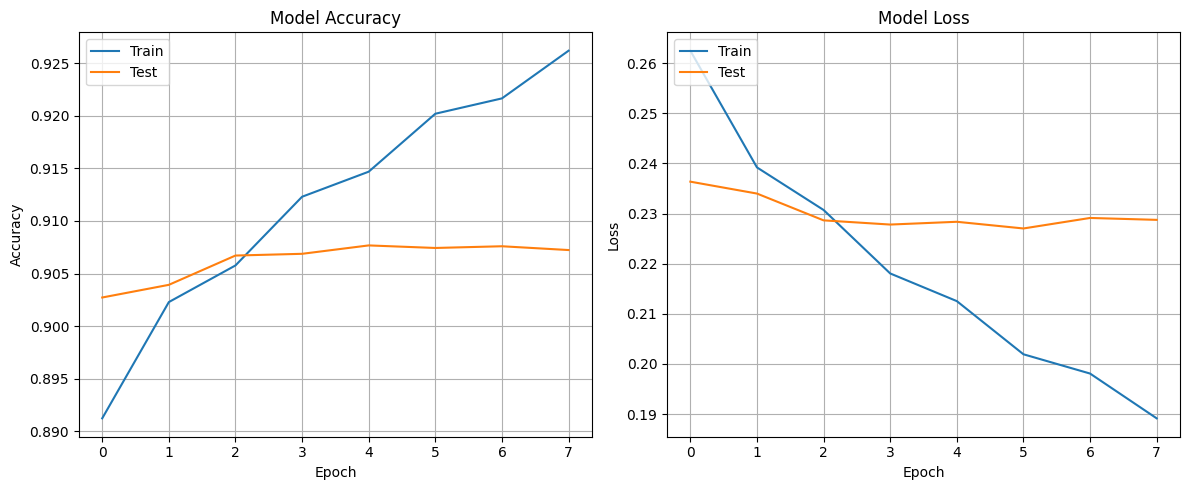

In [60]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
print("Gathering true labels and predictions from the test set...")

all_labels = []
all_predictions = []

test_generator = batch_generator(test_output_path, BATCH_SIZE, VOCAB_SIZE)

for i, (X_batch, y_batch) in enumerate(test_generator):
    # We only need to iterate through the number of validation steps
    if i >= validation_steps:
        break
    
    # Get model predictions for the batch (outputs probabilities)
    batch_predictions = model.predict(X_batch, verbose=0)
    
    # Append the true labels and predictions to our lists
    all_labels.extend(y_batch)
    all_predictions.extend(batch_predictions.flatten())

# Convert lists to NumPy arrays
y_true = np.array(all_labels)
y_pred_probs = np.array(all_predictions)

# Convert probabilities to class labels (0 or 1) using a 0.5 threshold
y_pred_classes = np.where(y_pred_probs > 0.5, 1, 0)

print("Finished gathering predictions.")

Gathering true labels and predictions from the test set...
Finished gathering predictions.



Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.91      0.90      0.91    200000
Positive (1)       0.91      0.91      0.91    200000

    accuracy                           0.91    400000
   macro avg       0.91      0.91      0.91    400000
weighted avg       0.91      0.91      0.91    400000


Confusion Matrix:


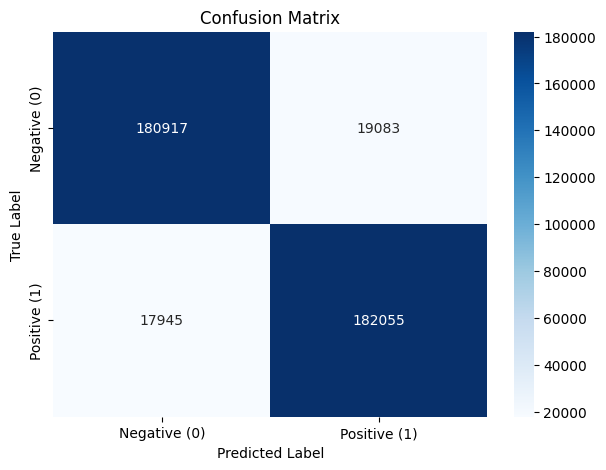

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print the classification report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Negative (0)', 'Positive (1)']))

# Create and plot the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

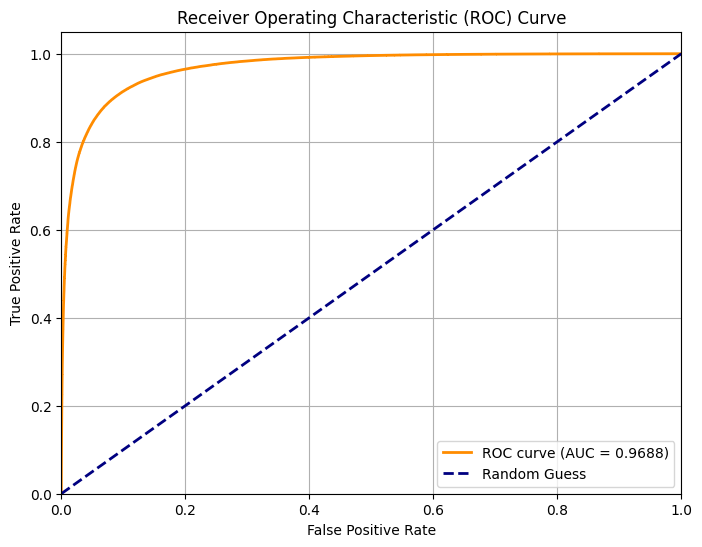

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


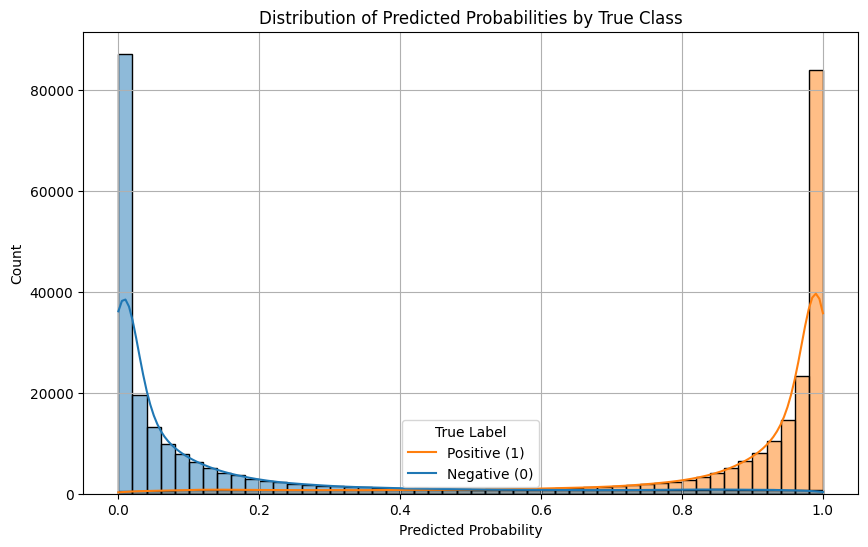

In [64]:
# Create a DataFrame for easy plotting
df_results = pd.DataFrame({
    'True Label': y_true,
    'Predicted Probability': y_pred_probs
})

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='Predicted Probability', hue='True Label', kde=True, bins=50)
plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend(title='True Label', labels=['Positive (1)', 'Negative (0)'])
plt.grid(True)
plt.show()